In [1]:
import csv
import cv2
import numpy as np
import time
from keras.callbacks import ModelCheckpoint, Callback

Using TensorFlow backend.
/Users/tavant/miniconda3/envs/carnd-term1-cpu/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
file_contains_header = False
dev_mode = False
no_of_images_to_read_in_dev_mode = 4


In [3]:
# Read the data collected in csv file

samples = []

def read_samples(filename):
    with open(filename) as csvFile:
        reader = csv.reader(csvFile)
        first_line = True
        for sample in reader:
            if(first_line and file_contains_header):
                first_line = False
                continue
            samples.append(sample)
            if(dev_mode and len(samples) >= no_of_images_to_read_in_dev_mode):
                break


read_samples('../CarND-Behavioral-Cloning-P3-My-Data/track1_forward_2_laps/driving_log.csv')
read_samples('../CarND-Behavioral-Cloning-P3-My-Data/track1_reverse_2_laps/driving_log.csv')
read_samples('../CarND-Behavioral-Cloning-P3-My-Data/track1_shoulder_to_road_1_lap/driving_log.csv')
read_samples('../CarND-Behavioral-Cloning-P3-My-Data/track2_forward_2_laps/driving_log.csv')
read_samples('../CarND-Behavioral-Cloning-P3-My-Data/track1_smooth_curves/driving_log.csv')
read_samples('../CarND-Behavioral-Cloning-P3-My-Data/track1_smooth_curves_2/driving_log.csv')
read_samples('../CarND-Behavioral-Cloning-P3-My-Data/track1_smooth_curves_3/driving_log.csv')
#read_samples('../CarND-Behavioral-Cloning-P3-My-Data/udacity_data/data/driving_log.csv')


In [4]:
# Print the histogram of the data points
print('sample count is ', len(samples))

from sklearn.utils import shuffle
samples = shuffle(samples)
print('sample count is ', len(samples))

def visualize_steering_angles_histogram(samples, num_bins = 20):
    steering_angles = []

    for sample in samples:
        steering_angles.append(sample[3])
    steering_angles = np.array(steering_angles).astype(np.float)
    #print(samples[:][3])
    print('steering_angles ', len(steering_angles))
    #steering_angles = steering_angles[0:5000]
    #print('steering_angles ', len(steering_angles))


    import matplotlib.pyplot as plt

    
    avg_samples_per_bin = len(steering_angles)/num_bins
    hist, bins = np.histogram(steering_angles, num_bins)

    print('hist ', hist)
    print('bins ', bins)
    print('avg_samples_per_bin ',avg_samples_per_bin)

    width = 0.7 * (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    plt.bar(center, hist, align='center', width=width)
    plt.plot((np.min(steering_angles), np.max(steering_angles)), (avg_samples_per_bin, avg_samples_per_bin), 'k-')
    #plt.show()
    
    return 

num_bins = 20
visualize_steering_angles_histogram(samples, num_bins)

sample count is  22635
sample count is  22635
steering_angles  22635
hist  [  450   159   145   300   317   491   628   812   789   624 14733   646
   567   471   310   306   302   142   167   276]
bins  [-1.  -0.9 -0.8 -0.7 -0.6 -0.5 -0.4 -0.3 -0.2 -0.1  0.   0.1  0.2  0.3
  0.4  0.5  0.6  0.7  0.8  0.9  1. ]
avg_samples_per_bin  1131.75


steering_angles  8563
hist  [450 159 145 300 317 491 628 812 789 624 661 646 567 471 310 306 302 142
 167 276]
bins  [-1.  -0.9 -0.8 -0.7 -0.6 -0.5 -0.4 -0.3 -0.2 -0.1  0.   0.1  0.2  0.3
  0.4  0.5  0.6  0.7  0.8  0.9  1. ]
avg_samples_per_bin  428.15


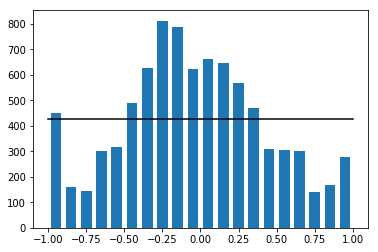

In [5]:
def flatten_data_point(samples, bin_left, bin_right, factor_ratio_to_retain = 0.5):
    # Flatten the data points
    flattened_samples = []

    #steering_angle_to_flatten = 0
    avg_samples_per_bin = len(samples)/num_bins
    count = 0
    for sample in samples:
        #if(float(sample[3]) == steering_angle_to_flatten):
        if(float(sample[3]) >= bin_left and float(sample[3]) < bin_right ):
            if(count <= int(avg_samples_per_bin * factor_ratio_to_retain )):
                flattened_samples.append(sample)
            count = count+1
        else:
            flattened_samples.append(sample)

    #avg_samples_per_bin = len(steering_angles)/num_bins
    #hist, bins = np.histogram(steering_angles, num_bins)
    #plt.bar(center, hist, align='center', width=width)
    #plt.plot((np.min(flattened_samples), np.max(flattened_samples)), (avg_samples_per_bin, avg_samples_per_bin), 'k-')


    visualize_steering_angles_histogram(flattened_samples)
    return flattened_samples

avg_samples_per_bin = len(samples)/num_bins
factor_ratio_to_retain = 0.5
samples = flatten_data_point(samples, bin_left = 0, bin_right=0.1, factor_ratio_to_retain = 0.45)
#samples = flatten_data_point(samples, bin_left = 0.1, bin_right=0.2, factor_ratio_to_retain = 0.8)
#samples = flatten_data_point(samples, bin_left = -0.1, bin_right=0, factor_ratio_to_retain = 0.8)
#samples = flatten_data_point(samples, bin_left = -0.2, bin_right=-0.1, factor_ratio_to_retain = 0.7)
#samples = flatten_data_point(samples, bin_left = -0.3, bin_right=-0.2, factor_ratio_to_retain = 0.5)





In [6]:
start_time = time.time()



# Split the data between training and validation set
from sklearn.model_selection import train_test_split
from random import shuffle
train_samples, validation_samples = train_test_split(samples, test_size=0.2)



In [7]:
# Modify the brightness of the image
def _get_brightnessed_image(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    random_bright = .25 + np.random.uniform()
    img[:,:,2] = img[:,:,2] * random_bright
    img = cv2.cvtColor(img, cv2.COLOR_HSV2BGR)
    return img

In [8]:
image_shape = (160,320,3)

def generator(samples, batch_size=32):
    num_samples = len(samples)
    #relative_path = '../CarND-Behavioral-Cloning-P3-data/data/IMG'
    relative_path = '../CarND-Behavioral-Cloning-P3-My-Data'
    while 1:
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset: offset+batch_size]
            images = []
            measurements = []
            
            for batch_sample in batch_samples:
                for i in range(3):
                    image_file_name = batch_sample[i].split(':')[-1]

                    relative_file_name = relative_path + image_file_name
                    relative_file_name = relative_file_name.replace('\\','//')
                    input_image = cv2.imread(relative_file_name)

                    #print(batch_sample[i].split(':'))
                    #print('image_file_name ', image_file_name)
                    #print('relative_file_name ', relative_file_name)
                    #print('input_image file name ', relative_file_name)
                    #print('input_image ', input_image)
                    #print('input_image.shape ', input_image.shape)

                    
                    # Modify the brightness of the image
                    #if np.random.uniform() < 0.5:
                        #input_image = _get_brightnessed_image(input_image)

                    images.append(input_image)

                    measurement = float(batch_sample[3])
                    correction_factor = 0.2
                    if(i == 1):
                        measurement = measurement + correction_factor
                    elif(i == 2):
                        measurement = measurement - correction_factor
                    measurements.append(measurement)

                    # Augment data by flipping the image and negating the measurement
                    images.append(cv2.flip(input_image,1))
                    measurements.append(-1.0 * measurement)
                    

            X_train = np.array(images)
            y_train = np.array(measurements)
            #import sklearn.utils.shuffle
            yield (X_train, y_train)

print('no. of training samples is  ', len(train_samples))
print('no. of validation samples is  ', len(validation_samples))

# compile and train the model using the generator function
train_generator = generator(train_samples, batch_size=32)
validation_generator = generator(validation_samples, batch_size=32)

print("calling the train generator")
#print((next(train_generator)))

from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Convolution2D, MaxPooling2D, Cropping2D, Dropout
from keras.regularizers import l2, activity_l2

model = Sequential()
model.add(Lambda(lambda x: x/255.0 - 0.5, input_shape=(image_shape)))
model.add(Cropping2D(cropping=((70,25), (0,0))))

# Lenet Architecture
#model.add(Convolution2D(6,5,5, activation = "relu"))
#model.add(MaxPooling2D())
#model.add(Convolution2D(6,5,5, activation = "relu"))
#model.add(MaxPooling2D())
#model.add(Flatten())
#model.add(Dense(120))
#model.add(Dense(84))
#model.add(Dense(1))

# NVIDIA Architecture
model.add(Convolution2D(24,5,5, subsample=(2,2), border_mode='valid', W_regularizer=l2(0.0005), activation = "relu"))
#model.add(Dropout(0.5))
model.add(Convolution2D(36,5,5, subsample=(2,2), border_mode='valid', W_regularizer=l2(0.0005), activation = "relu"))
model.add(Convolution2D(48,5,5, subsample=(2,2), border_mode='valid', W_regularizer=l2(0.0005), activation = "relu"))
model.add(Convolution2D(64,3,3, border_mode='valid', W_regularizer=l2(0.0005), activation = "relu"))
model.add(Convolution2D(64,3,3, border_mode='valid', W_regularizer=l2(0.0005), activation = "relu"))

model.add(Flatten())
#model.add(Dropout(0.5))
model.add(Dense(100))
#model.add(Dropout(0.5))
model.add(Dense(50))
#model.add(Dropout(0.5))
model.add(Dense(10))
model.add(Dense(1))

model.compile(loss='mse', optimizer = 'adam')

checkpoint = ModelCheckpoint('model_tune_do_elu_{epoch:02d}.h5')

#model.fit(X_train, y_train, shuffle=True, validation_split=0.2, nb_epoch=5)
model.fit_generator(train_generator, samples_per_epoch= len(train_samples), validation_data=validation_generator, nb_val_samples=len(validation_samples), nb_epoch=7, callbacks=[checkpoint])


model.save('model.h5')

print('Time Taken to load the images and train the model : ', time.time() - start_time)



no. of training samples is   6850
no. of validation samples is   1713
calling the train generator
Epoch 1/7
6720/6850 [============================>.] - ETA: 1s - loss: 0.2319

/Users/tavant/miniconda3/envs/carnd-term1-cpu/lib/python3.5/site-packages/keras/engine/training.py:1569: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


6912/6850 [==============================] - 78s - loss: 0.2298 - val_loss: 0.1969
Epoch 2/7
6912/6850 [==============================] - 80s - loss: 0.1902 - val_loss: 0.1600
Epoch 3/7
6912/6850 [==============================] - 83s - loss: 0.1518 - val_loss: 0.1272
Epoch 4/7
6912/6850 [==============================] - 83s - loss: 0.1376 - val_loss: 0.1392
Epoch 5/7
6912/6850 [==============================] - 84s - loss: 0.1332 - val_loss: 0.1185
Epoch 6/7
6924/6850 [==============================] - 150s - loss: 0.1349 - val_loss: 0.1414
Epoch 7/7
6912/6850 [==============================] - 163s - loss: 0.1209 - val_loss: 0.1285
Time Taken to load the images and train the model :  725.2886390686035
